In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration (FAST + correct ground-truth recovery) ---
Lx, Ly = 50.0, 50.0
Nx, Ny = 64, 64
dt = 1e-3
n_seconds = 0.5
save_every = 1  # IMPORTANT: set to 1 for true PDE coefficient recovery
seed = 42

dx = Lx / Nx
dy = Ly / Ny
total_steps = int(n_seconds / dt)
n_frames = total_steps // save_every
DT = dt * save_every

print({
    'Nx': Nx, 'Ny': Ny, 'dx': dx, 'dy': dy,
    'dt': dt, 'save_every': save_every, 'DT': DT,
    'total_steps': total_steps, 'n_frames': n_frames
})

{'Nx': 64, 'Ny': 64, 'dx': 0.78125, 'dy': 0.78125, 'dt': 0.001, 'save_every': 1, 'DT': 0.001, 'total_steps': 500, 'n_frames': 500}


In [2]:
# --- Periodic-BC derivatives (matches np.roll discretization) ---
def laplacian(f2d: np.ndarray, dx: float, dy: float) -> np.ndarray:
    return (
        (np.roll(f2d, -1, axis=0) - 2*f2d + np.roll(f2d, 1, axis=0)) / (dx**2)
        + (np.roll(f2d, -1, axis=1) - 2*f2d + np.roll(f2d, 1, axis=1)) / (dy**2)
    )

def gradients(f2d: np.ndarray, dx: float, dy: float) -> tuple[np.ndarray, np.ndarray]:
    gx = (np.roll(f2d, -1, axis=0) - np.roll(f2d, 1, axis=0)) / (2*dx)
    gy = (np.roll(f2d, -1, axis=1) - np.roll(f2d, 1, axis=1)) / (2*dy)
    return gx, gy

def ks_rhs(u: np.ndarray, dx: float, dy: float) -> np.ndarray:
    lap = laplacian(u, dx=dx, dy=dy)
    bih = laplacian(lap, dx=dx, dy=dy)
    ux, uy = gradients(u, dx=dx, dy=dy)
    return -lap - bih - 0.5*(ux**2 + uy**2)

U shape: (500, 64, 64)
u range: -0.09916768934803566 0.10317702881067896


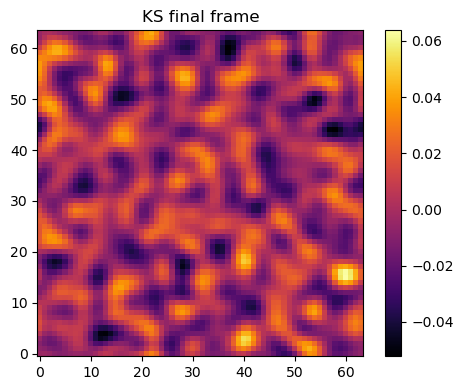

In [3]:
# --- Simulate 2D KS (explicit Euler, periodic BC) ---
rng = np.random.default_rng(seed)
u = rng.uniform(-0.1, 0.1, size=(Nx, Ny)).astype(np.float64)

U = np.zeros((n_frames, Nx, Ny), dtype=np.float64)
frame = 0
for step in range(total_steps):
    u = u + dt * ks_rhs(u, dx=dx, dy=dy)
    u = np.nan_to_num(u)
    if step % save_every == 0:
        U[frame] = u
        frame += 1

print('U shape:', U.shape)
print('u range:', float(U.min()), float(U.max()))

plt.figure(figsize=(5,4))
plt.imshow(U[-1], cmap='inferno', origin='lower')
plt.title('KS final frame')
plt.colorbar()
plt.tight_layout()
plt.show()

In [4]:
# --- Build regression dataset consistent with the simulator ---
# For Euler: (u_{k+1}-u_k)/DT ≈ RHS(u_k)
U_frames = U[:-1]
Ut = (U[1:] - U[:-1]) / DT

# Dictionary: EXACT KS terms only (to verify perfect recovery)
lap = np.empty_like(U_frames)
bih = np.empty_like(U_frames)
grad_sq = np.empty_like(U_frames)

for k in range(U_frames.shape[0]):
    u = U_frames[k]
    lap_k = laplacian(u, dx=dx, dy=dy)
    bih_k = laplacian(lap_k, dx=dx, dy=dy)
    ux_k, uy_k = gradients(u, dx=dx, dy=dy)
    lap[k] = lap_k
    bih[k] = bih_k
    grad_sq[k] = ux_k**2 + uy_k**2

term_names = ['∇²u', '∇⁴u', '|∇u|²']
terms = [lap, bih, grad_sq]

# Flatten and sample points (keeps it fast but still exact in this setting)
rng = np.random.default_rng(0)
n_total = Ut.size
n_sample = min(50_000, n_total)
flat_idx = rng.choice(n_total, size=n_sample, replace=False)

y = Ut.reshape(-1)[flat_idx]
X = np.column_stack([t.reshape(-1)[flat_idx] for t in terms])

valid = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[valid]
y = y[valid]

print('X shape:', X.shape, 'y shape:', y.shape)
print('y stats:', float(y.mean()), float(y.std()))

X shape: (50000, 3) y shape: (50000,)
y stats: 0.0005824567648833928 0.37341971631854826


In [5]:
# --- Model-4-style STRidge (NumPy-only) + evaluation ---
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - float(np.mean(y_true)))**2))
    return float(1.0 - ss_res/(ss_tot + 1e-18))

def standardize_fit(X: np.ndarray):
    mean = np.mean(X, axis=0)
    scale = np.std(X, axis=0)
    scale = np.where(scale > 0, scale, 1.0)
    return mean, scale

def standardize_transform(X: np.ndarray, mean: np.ndarray, scale: np.ndarray):
    return (X - mean) / scale

def ridge_fit(X: np.ndarray, y: np.ndarray, alpha: float) -> np.ndarray:
    XtX = X.T @ X
    Xty = X.T @ y
    p = XtX.shape[0]
    return np.linalg.solve(XtX + alpha*np.eye(p), Xty)

def stridge(X: np.ndarray, y: np.ndarray, alpha: float = 1e-6, threshold: float = 1e-10, max_iter: int = 25) -> np.ndarray:
    mean, scale = standardize_fit(X)
    Xs = standardize_transform(X, mean, scale)
    coeffs = ridge_fit(Xs, y, alpha=alpha).copy()
    for _ in range(max_iter):
        small = np.abs(coeffs) < threshold
        if small.all():
            coeffs[:] = 0.0
            break
        coeffs[small] = 0.0
        big = ~small
        coeffs_big = ridge_fit(Xs[:, big], y, alpha=alpha).copy()
        coeffs = np.zeros_like(coeffs)
        coeffs[big] = coeffs_big
    return coeffs / (scale + 1e-12)

# Train/test split
rng = np.random.default_rng(1)
perm = rng.permutation(len(y))
split = int(0.7 * len(y))
tr, te = perm[:split], perm[split:]
X_tr, y_tr = X[tr], y[tr]
X_te, y_te = X[te], y[te]

alpha = 1e-6
thr = 1e-10
c = stridge(X_tr, y_tr, alpha=alpha, threshold=thr)

y_pred_tr = X_tr @ c
y_pred_te = X_te @ c

print('STRidge params:', {'alpha': alpha, 'threshold': thr})
print('Train: R2=', r2_score(y_tr, y_pred_tr), 'RMSE=', rmse(y_tr, y_pred_tr))
print('Test : R2=', r2_score(y_te, y_pred_te), 'RMSE=', rmse(y_te, y_pred_te))

print('\nRecovered coefficients:')
for name, ci in zip(term_names, c):
    print(f'  {name:6s}: {ci:+.6f}')

gt = {'∇²u': -1.0, '∇⁴u': -1.0, '|∇u|²': -0.5}
print('\nRelative % errors vs ground truth:')
for name, ci in zip(term_names, c):
    g = gt[name]
    rel = abs(ci - g)/(abs(g) + 1e-12)*100
    print(f'  {name:6s}: gt={g:+.6f}, est={ci:+.6f}, rel_err={rel:.6f}%')

STRidge params: {'alpha': 1e-06, 'threshold': 1e-10}
Train: R2= 1.0 RMSE= 3.216230714271724e-11
Test : R2= 1.0 RMSE= 3.1960883311806305e-11

Recovered coefficients:
  ∇²u   : -1.000000
  ∇⁴u   : -1.000000
  |∇u|² : -0.500000

Relative % errors vs ground truth:
  ∇²u   : gt=-1.000000, est=-1.000000, rel_err=0.000000%
  ∇⁴u   : gt=-1.000000, est=-1.000000, rel_err=0.000000%
  |∇u|² : gt=-0.500000, est=-0.500000, rel_err=0.000000%


## Optional: show why coarse sampling breaks coefficient recovery
If you change `save_every` from 1 → 10, you are no longer matching the instantaneous PDE. You are matching a **10-step coarse operator**, so coefficients will generally not match `(-1, -1, -0.5)` even if $R^2$ is decent.

Run the next cell to confirm this behavior.

In [6]:
# --- Coarse sampling experiment (expected: NOT ground-truth coefficients) ---
save_every_coarse = 10
DTc = dt * save_every_coarse
total_steps_c = int(n_seconds / dt)
n_frames_c = total_steps_c // save_every_coarse

rng = np.random.default_rng(seed)
u = rng.uniform(-0.1, 0.1, size=(Nx, Ny)).astype(np.float64)
Uc = np.zeros((n_frames_c, Nx, Ny), dtype=np.float64)
frame = 0
for step in range(total_steps_c):
    u = u + dt * ks_rhs(u, dx=dx, dy=dy)
    u = np.nan_to_num(u)
    if step % save_every_coarse == 0:
        Uc[frame] = u
        frame += 1

U_frames = Uc[:-1]
Utc = (Uc[1:] - Uc[:-1]) / DTc

lap = np.empty_like(U_frames)
bih = np.empty_like(U_frames)
grad_sq = np.empty_like(U_frames)
for k in range(U_frames.shape[0]):
    u = U_frames[k]
    lap_k = laplacian(u, dx=dx, dy=dy)
    bih_k = laplacian(lap_k, dx=dx, dy=dy)
    ux_k, uy_k = gradients(u, dx=dx, dy=dy)
    lap[k] = lap_k
    bih[k] = bih_k
    grad_sq[k] = ux_k**2 + uy_k**2

term_names = ['∇²u', '∇⁴u', '|∇u|²']
terms = [lap, bih, grad_sq]

rng = np.random.default_rng(0)
n_total = Utc.size
n_sample = min(50_000, n_total)
flat_idx = rng.choice(n_total, size=n_sample, replace=False)
y = Utc.reshape(-1)[flat_idx]
X = np.column_stack([t.reshape(-1)[flat_idx] for t in terms])
valid = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[valid]
y = y[valid]

perm = np.random.default_rng(1).permutation(len(y))
split = int(0.7 * len(y))
tr, te = perm[:split], perm[split:]
c = stridge(X[tr], y[tr], alpha=1e-6, threshold=1e-10)

print('Recovered coefficients (coarse sampling):')
for name, ci in zip(term_names, c):
    print(f'  {name:6s}: {ci:+.6f}')

Recovered coefficients (coarse sampling):
  ∇²u   : +0.777515
  ∇⁴u   : -0.518833
  |∇u|² : -0.604284


## Noise stress test (measurement noise on frames)
This section adds i.i.d. Gaussian noise to the observed frames $u(x,y,t)$ and re-runs the *same* identification pipeline.
We scale noise by the standard deviation of the clean data: `sigma = noise_rel * std(U)`.
Expected: as noise increases, coefficient errors increase, and at some point sparsity/accuracy breaks.

noise_rel=0.000 (sigma=0.000e+00) | R2_test=1.0000 | rmse_test=2.990e-11 | %err=[0.00, 0.00, 0.00]
noise_rel=0.005 (sigma=1.080e-04) | R2_test=0.8622 | rmse_test=1.478e-01 | %err=[1.14, 0.79, 33.21]
noise_rel=0.010 (sigma=2.160e-04) | R2_test=0.6182 | rmse_test=2.955e-01 | %err=[2.84, 2.29, 77.56]
noise_rel=0.020 (sigma=4.320e-04) | R2_test=0.3115 | rmse_test=5.906e-01 | %err=[7.78, 7.40, 198.79]
noise_rel=0.050 (sigma=1.080e-03) | R2_test=0.1140 | rmse_test=1.470e+00 | %err=[30.08, 38.21, 799.24]
noise_rel=0.100 (sigma=2.160e-03) | R2_test=0.0955 | rmse_test=2.904e+00 | %err=[35.83, 125.02, 2355.48]


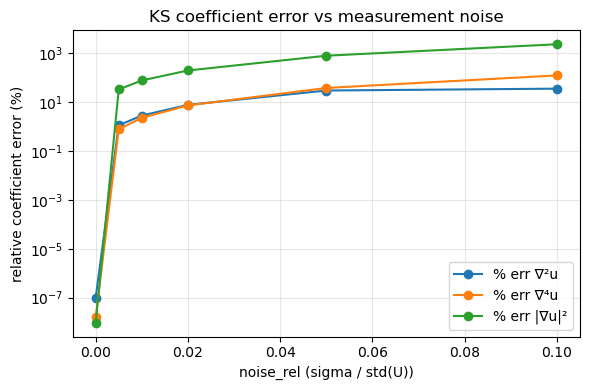

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse: laplacian(), gradients(), stridge(), r2_score(), rmse() from earlier cells.
# Uses the SAME true dictionary: [∇²u, ∇⁴u, |∇u|²].

def fit_ks_coeffs_from_frames(U_obs: np.ndarray, DT: float, dx: float, dy: float, n_sample: int = 50_000, alpha: float = 1e-6, threshold: float = 1e-10):
    """Estimate KS coefficients from observed frames U_obs using STRidge."""
    U_frames = U_obs[:-1]
    Ut = (U_obs[1:] - U_obs[:-1]) / DT
    lap = np.empty_like(U_frames)
    bih = np.empty_like(U_frames)
    grad_sq = np.empty_like(U_frames)
    for k in range(U_frames.shape[0]):
        u = U_frames[k]
        lap_k = laplacian(u, dx=dx, dy=dy)
        bih_k = laplacian(lap_k, dx=dx, dy=dy)
        ux_k, uy_k = gradients(u, dx=dx, dy=dy)
        lap[k] = lap_k
        bih[k] = bih_k
        grad_sq[k] = ux_k**2 + uy_k**2
    terms = [lap, bih, grad_sq]
    term_names = ['∇²u', '∇⁴u', '|∇u|²']

    rng = np.random.default_rng(123)
    n_total = Ut.size
    n_sample = int(min(n_sample, n_total))
    flat_idx = rng.choice(n_total, size=n_sample, replace=False)
    y = Ut.reshape(-1)[flat_idx]
    X = np.column_stack([t.reshape(-1)[flat_idx] for t in terms])
    valid = np.isfinite(X).all(axis=1) & np.isfinite(y)
    X = X[valid]
    y = y[valid]

    perm = rng.permutation(len(y))
    split = int(0.7 * len(y))
    tr, te = perm[:split], perm[split:]
    c = stridge(X[tr], y[tr], alpha=alpha, threshold=threshold)
    y_pred_te = X[te] @ c
    return {
        'term_names': term_names,
        'coeffs': c,
        'r2_test': r2_score(y[te], y_pred_te),
        'rmse_test': rmse(y[te], y_pred_te),
    }

# Noise sweep (relative to std of clean U)
U_clean = U.copy()
sigma0 = float(np.std(U_clean))
noise_levels = [0.0, 0.005, 0.01, 0.02, 0.05, 0.1]  # relative noise
gt = {'∇²u': -1.0, '∇⁴u': -1.0, '|∇u|²': -0.5}

rows = []
for nl in noise_levels:
    sigma = nl * sigma0
    rng = np.random.default_rng(999)
    U_noisy = U_clean + rng.normal(0.0, sigma, size=U_clean.shape)
    res = fit_ks_coeffs_from_frames(U_noisy, DT=DT, dx=dx, dy=dy, n_sample=50_000, alpha=1e-6, threshold=1e-10)
    c = res['coeffs']
    errs = []
    for name, ci in zip(res['term_names'], c):
        g = gt[name]
        errs.append(abs(float(ci) - g) / (abs(g) + 1e-12) * 100.0)
    rows.append((nl, sigma, res['r2_test'], res['rmse_test'], *errs))
    print(f"noise_rel={nl:.3f} (sigma={sigma:.3e}) | R2_test={res['r2_test']:.4f} | rmse_test={res['rmse_test']:.3e} | %err=[{errs[0]:.2f}, {errs[1]:.2f}, {errs[2]:.2f}]")

rows = np.array(rows, dtype=float)
noise_rel = rows[:, 0]
err_lap = rows[:, 4]
err_bih = rows[:, 5]
err_gsq = rows[:, 6]

plt.figure(figsize=(6,4))
plt.plot(noise_rel, err_lap, 'o-', label='% err ∇²u')
plt.plot(noise_rel, err_bih, 'o-', label='% err ∇⁴u')
plt.plot(noise_rel, err_gsq, 'o-', label='% err |∇u|²')
plt.yscale('log')
plt.xlabel('noise_rel (sigma / std(U))')
plt.ylabel('relative coefficient error (%)')
plt.title('KS coefficient error vs measurement noise')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()